### Backtest Results: Analysis and Visualization (v2)

This notebook loads the master results file and performs in-depth analysis and visualization, correctly distinguishing between different strategy parameter sets.

**Workflow:**
1.  **Setup:** Configure paths and define the columns that identify a unique strategy.
2.  **Load Data:** Load the master backtest results file.
3.  **Aggregate Analysis:** Calculate performance metrics by grouping on **unique strategy parameters** to ensure a correct, apples-to-apples comparison.
4.  **Visualize Evolving Sharpe:** Plot the evolving Sharpe ratio for the best-performing strategy run.
5.  **Visualize Equity Curve:** Plot the cumulative return (equity curve) for the best-performing strategy run.

### Setup and Configuration

In [60]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np

# --- Project Path Setup ---
NOTEBOOK_DIR = Path.cwd()
ROOT_DIR = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == 'notebooks' else NOTEBOOK_DIR
if str(ROOT_DIR) not in sys.path:
    sys.path.append(str(ROOT_DIR))
SRC_DIR = ROOT_DIR / 'src'
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

# --- Local Imports ---
import utils
# from stocks.notebooks.config_obsolete import ANNUAL_RISK_FREE_RATE, TRADING_DAYS_PER_YEAR
from config import ANNUAL_RISK_FREE_RATE, DAILY_RISK_FREE_RATE, TRADING_DAYS_PER_YEAR

# --- Analysis Parameters ---
# ANNUAL_RISK_FREE_RATE = 0.04
# TRADING_DAYS_PER_YEAR = 252
MIN_PERIODS_FOR_SHARPE = 10
BENCHMARK_TICKER = "VGT" # <--- ADD THIS LINE 

# --- !! CRITICAL: Define columns that identify a unique strategy run !! ---
STRATEGY_ID_COLS = [
    'n_select_requested',
    'filter_min_price',
    'filter_min_avg_volume_m',
    'score_weight_rsi', # Add/remove any parameters you tune
]

# --- File Path Construction ---
BACKTEST_DIR = ROOT_DIR / 'output' / 'backtest_results'
SOURCE_PATH = BACKTEST_DIR / 'backtest_master_results.parquet'
DATA_DIR = ROOT_DIR / 'data'

# --- Notebook Setup ---
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1500)
pd.set_option('display.float_format', '{:.4f}'.format)
%load_ext autoreload
%autoreload 2

# --- Verification ---
print(f"Source file for analysis: {SOURCE_PATH}")
print(f"Identifying unique strategies by: {STRATEGY_ID_COLS}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Source file for analysis: c:\Users\ping\Files_win10\python\py311\stocks\output\backtest_results\backtest_master_results.parquet
Identifying unique strategies by: ['n_select_requested', 'filter_min_price', 'filter_min_avg_volume_m', 'score_weight_rsi']


### Step 1: Load Backtest Results

In [61]:
print(f"--- Step 1: Loading data from {SOURCE_PATH.name} ---")

try:
    df_results = pd.read_parquet(SOURCE_PATH)
    # Ensure date column is in datetime format for analysis
    df_results['actual_selection_date_used'] = pd.to_datetime(df_results['actual_selection_date_used'])
    print(f"✅ Successfully loaded and prepared data for {len(df_results)} backtest runs.")
    # print(df_results)
    # print(df_results.head(24))    
    display(df_results.head(3))
    display(df_results.tail(3))
    # display(df_results)         
except FileNotFoundError:
    print(f"❌ ERROR: Source file not found at {SOURCE_PATH}. Halting execution.")
    df_results = None          

--- Step 1: Loading data from backtest_master_results.parquet ---
✅ Successfully loaded and prepared data for 120 backtest runs.


,actual_selection_date_used,average_return,filter_max_debt_eq,filter_min_avg_volume_m,filter_min_price,filter_min_roe_pct,inv_vol_col_name,log_file,n_select_actual,n_select_requested,num_attempted_trades,num_failed_or_skipped_trades,num_selected_tickers,num_successful_trades,portfolio_return,portfolio_return_normalized,run_timestamp,scheme,score_weight_change,score_weight_rel_volume,score_weight_rsi,score_weight_volatility,selection_date,sharpe_ratio_period,std_dev_return,total_weight_traded,win_rate
0,2025-06-20,0.0124,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250624_180741.log,10,10,10,0,10,10,0.0124,0.0124,2025-06-24 18:07:41,EW,0.3500,0.2000,0.3500,0.1000,2025-06-20,1.1240,0.0109,1.0000,0.9000
1,2025-06-20,0.0124,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250624_180741.log,10,10,10,0,10,10,0.0123,0.0123,2025-06-24 18:07:41,IV,0.3500,0.2000,0.3500,0.1000,2025-06-20,1.1240,0.0109,1.0000,0.9000
2,2025-06-20,0.0124,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250624_180741.log,10,10,10,0,10,10,0.0126,0.0126,2025-06-24 18:07:41,SW,0.3500,0.2000,0.3500,0.1000,2025-06-20,1.1240,0.0109,1.0000,0.9000


,actual_selection_date_used,average_return,filter_max_debt_eq,filter_min_avg_volume_m,filter_min_price,filter_min_roe_pct,inv_vol_col_name,log_file,n_select_actual,n_select_requested,num_attempted_trades,num_failed_or_skipped_trades,num_selected_tickers,num_successful_trades,portfolio_return,portfolio_return_normalized,run_timestamp,scheme,score_weight_change,score_weight_rel_volume,score_weight_rsi,score_weight_volatility,selection_date,sharpe_ratio_period,std_dev_return,total_weight_traded,win_rate
117,2025-04-25,0.0085,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250624_180741.log,10,10,10,0,10,10,0.0085,0.0085,2025-06-24 18:07:41,EW,0.3500,0.2000,0.3500,0.1000,2025-04-25,0.4129,0.0203,1.0000,0.7000
118,2025-04-25,0.0085,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250624_180741.log,10,10,10,0,10,10,0.0075,0.0075,2025-06-24 18:07:41,IV,0.3500,0.2000,0.3500,0.1000,2025-04-25,0.4129,0.0203,1.0000,0.7000
119,2025-04-25,0.0085,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250624_180741.log,10,10,10,0,10,10,0.0096,0.0096,2025-06-24 18:07:41,SW,0.3500,0.2000,0.3500,0.1000,2025-04-25,0.4129,0.0203,1.0000,0.7000


### lateest_date should be max + 5 more dats

In [79]:
# Get the full date range of our entire backtest period
earliest_date = df_results['actual_selection_date_used'].min()
latest_date = df_results['actual_selection_date_used'].max() + pd.offsets.BDay(0)

print(f"Earliest 'actual_selection_date_used' in backtest: {earliest_date}")
print(f"Latest 'actual_selection_date_used' in backtest:   {latest_date}")

Earliest 'actual_selection_date_used' in backtest: 2025-04-25 00:00:00
Latest 'actual_selection_date_used' in backtest:   2025-06-20 00:00:00


### Step 2: Load Price Data

In [63]:
_df_prices = pd.read_parquet(DATA_DIR / 'df_adj_close.parquet')

# Sort the DataFrame by its index, modifying it in place.
_df_prices.sort_index(inplace=True)

# --- Step 4: Use .loc with the new, extended end date ---
df_prices = _df_prices.loc[earliest_date:latest_date]
print(f"Loaded price data with {len(_df_prices)} rows and {len(_df_prices.columns)} columns.")
print(f"df_prices data:")
display(df_prices.head(3))
display(df_prices.tail(3))

benchmark_price_series = df_prices[BENCHMARK_TICKER]
print(f'benchmark_price_series {BENCHMARK_TICKER} prices:')
display(benchmark_price_series.head(3))
display(benchmark_price_series.tail(3))

Loaded price data with 349 rows and 1559 columns.
df_prices data:


Ticker,A,AA,AAL,AAON,AAPL,ABBV,ABEV,ABNB,ABT,ACGL,ACHR,ACI,ACM,ACN,ACWI,ACWV,ACWX,ADBE,ADC,ADI,ADM,ADP,ADSK,ADT,AEE,AEG,AEM,AEP,AER,AES,AFG,AFL,AFRM,AGCO,AGG,AGI,AGNC,AIFU,AIG,AIQ,AIRR,AIT,AIZ,AJG,AKAM,AL,ALB,ALC,ALGN,ALK,ALL,ALLE,ALLY,ALNY,ALSN,ALV,AM,AMAT,AMCR,AMD,AME,AMGN,AMH,AMLP,AMP,AMT,AMX,AMZN,AN,ANET,ANSS,AON,AOS,APA,APD,APG,APH,APO,APP,APPF,APTV,AR,ARCC,ARE,ARES,ARGX,ARKB,ARKK,ARM,ARMK,ARW,AS,ASML,ASND,ASR,ASTS,ASX,ATI,ATO,ATR,AU,AUR,AVAV,AVB,AVDE,AVDV,AVEM,AVGO,AVLV,AVTR,AVUS,AVUV,AVY,AWI,AWK,AXON,AXP,AXS,AXTA,AYI,AZEK,AZN,AZO,B,BA,BABA,BAC,BAH,BALL,BAM,BAP,BAX,BBAX,BBCA,BBD,BBEU,BBIN,BBIO,BBJP,BBUS,BBVA,BBWI,BBY,BCE,BCH,BCS,BDX,BEKE,BEN,BEP,BF-A,BF-B,BFAM,BG,BHP,BIDU,BIIB,BIL,BILI,BILS,BINC,BIO,BIP,BIRK,BITB,BIV,BJ,BK,BKLC,BKLN,BKNG,BKR,BLD,BLDR,BLK,BLV,BMI,BMO,BMRN,BMY,BN,BND,BNDX,BNS,BNT,BNTX,BOKF,BOND,BOXX,BP,BPMC,BPOP,BR,BRBR,BRFS,BRK-A,BRK-B,BRKR,BRO,BROS,BRX,BSAC,BSBR,BSCP,BSCQ,BSCR,BSV,BSX,BSY,BTI,BUD,BUFR,BURL,BWA,BWXT,BX,BXP,BXSL,BYD,BZ,C,CACC,CACI,CAE,CAG,CAH,CALF,CARR,CART,CASY,CAT,CAVA,CB,CBOE,CBRE,CBSH,CCCS,CCEP,CCI,CCJ,CCK,CCL,CDE,CDNS,CDP,CDW,CE,CEF,CEG,CELH,CF,CFG,CFLT,CFR,CG,CGCP,CGDV,CGGO,CGGR,CGMU,CGUS,CGXU,CHD,CHDN,CHE,CHH,CHKP,CHRD,CHRW,CHT,CHTR,CHWY,CI,CIBR,CIEN,CIGI,CINF,CL,CLH,CLS,CLX,CM,CMA,CMCSA,CME,CMF,CMG,CMI,CMS,CNA,CNC,CNH,CNI,CNM,CNP,CNQ,COF,COHR,COIN,COKE,COO,COOP,COP,COR,CORT,COST,COWZ,CP,CPAY,CPB,CPNG,CPRT,CPT,CQP,CR,CRBG,CRDO,CRH,CRK,CRL,CRM,CRS,CRWD,CSCO,CSGP,CSL,CSX,CTAS,CTRA,CTSH,CTVA,CUBE,CVE,CVLT,CVNA,CVS,CVX,CW,CWAN,CWB,CWEN,CWEN-A,CWST,CX,CYBR,CZR,D,DAL,DAR,DASH,DAY,DB,DBEF,DBX,DCI,DD,DDOG,DDS,DE,DECK,DELL,DEO,DFAC,DFAE,DFAI,DFAS,DFAT,DFAU,DFAX,DFCF,DFEM,DFIC,DFIV,DFLV,DFSD,DFSV,DFUS,DFUV,DG,DGRO,DGRW,DGX,DHI,DHR,DIA,DIHP,DINO,DIS,DIVO,DKNG,DKS,DLB,DLN,DLR,DLTR,DOC,DOCS,DOCU,DON,DOV,DOW,DOX,DPZ,DRI,DRS,DSGX,DSI,DT,DTE,DTM,DUHP,DUK,DUOL,DVA,DVN,DVY,DXCM,DXJ,DY,DYNF,E,EA,EAGG,EAT,EBAY,EBR,EC,ECL,ED,EDU,EDV,EEM,EEMV,EFA,EFAV,EFG,EFV,EFX,EG,EGP,EHC,EIX,EL,ELAN,ELF,ELS,ELV,EMA,EMB,EME,EMLC,EMN,EMR,EMXC,ENB,ENPH,ENSG,ENTG,EOG,EPAM,EPD,EPI,EPRT,EQH,EQIX,EQNR,EQR,EQT,ERIC,ERIE,ERJ,ES,ESAB,ESGD,ESGE,ESGU,ESGV,ESLT,ESNT,ESS,ESTC,ET,ETN,ETR,ETSY,EUFN,EVR,EVRG,EW,EWBC,EWJ,EWT,EWY,EWZ,EXAS,EXC,EXE,EXEL,EXLS,EXP,EXPD,EXPE,EXR,EZU,F,FAF,FANG,FAST,FBCG,FBIN,FBND,FBTC,FCNCA,FCX,FDL,FDN,FDS,FDVV,FDX,FE,FELC,FELG,FER,FERG,FEZ,FFIV,FHN,FI,FICO,FIS,FITB,FIVE,FIX,FIXD,FLEX,FLOT,FLR,FLS,FLUT,FMS,FMX,FN,FND,FNDA,FNDE,FNDF,FNDX,FNF,FNV,FOUR,FOX,FOXA,FPE,FR,FRHC,FRT,FSEC,FSK,FSLR,FSS,FSV,FTAI,FTCS,FTEC,FTI,FTNT,FTS,FTSM,FTV,FUTU,FV,FVD,FWONA,FWONK,FXI,FYBR,G,GAP,GBIL,GBTC,GD,GDDY,GDX,GDXJ,GE,GEHC,GEN,GFI,GFL,GFS,GGAL,GGG,GH,GIB,GIL,GILD,GIS,GL,GLD,GLDM,GLPI,GLW,GM,GMAB,GME,GMED,GNRC,GOOG,GOOGL,GOVT,GPC,GPK,GPN,GRAB,GRMN,GS,GSIE,GSK,GSLC,GTLB,GTLS,GUNR,GVI,GWRE,GWW,H,HAL,HALO,HAS,HBAN,HCA,HD,HDB,HDV,HEFA,HEI,HEI-A,HES,HESM,HIG,HII,HIMS,HLI,HLN,HLNE,HLT,HMC,HMY,HOLX,HON,HOOD,HPE,HPQ,HQY,HRB,HRL,HSBC,HSIC,HST,HSY,HTHT,HUBB,HUBS,HUM,HWM,HYD,HYG,HYLB,IAGG,IAU,IBB,IBDR,IBIT,IBKR,IBM,IBN,ICE,ICL,ICLR,ICSH,IDA,IDCC,IDEV,IDV,IDXX,IEF,IEFA,IEI,IEMG,IEUR,IEX,IFF,IGF,IGIB,IGM,IGSB,IGV,IHG,IHI,IJH,IJJ,IJK,IJR,IJS,IJT,ILMN,IMO,INCY,INDA,INFA,INFY,ING,INGR,INSM,INTC,INTU,INVH,IONQ,IONS,IOO,IOT,IP,IPG,IQLT,IQV,IR,IRM,ISRG,ISTB,IT,ITA,ITOT,ITT,ITUB,ITW,IUSB,IUSG,IUSV,IVE,IVV,IVW,IVZ,IWB,IWD,IWF,IWM,IWN,IWO,IWP,IWR,IWS,IWV,IWY,IX,IXJ,IXN,IXUS,IYF,IYR,IYW,J,JAAA,JAVA,JAZZ,JBHT,JBL,JBTM,JCI,JCPB,JD,JEF,JEPI,JEPQ,JGRO,JHMM,JHX,JIRE,JKHY,JLL,JMBS,JMST,JNJ,JNK,JNPR,JOBY,JPIE,JPM,JPST,JQUA,JXN,K,KB,KBR,KBWB,KD,KDP,KEP,KEX,KEY,KEYS,KGC,KHC,KIM,KKR,KLAC,KMB,KMI,KMX,KNG,KNSL,KNTK,KNX,KO,KR,KRC,KRE,KSPI,KT,KTOS,KVUE,KVYO,KWEB,L,LAD,LAMR,LBRDA,LBRDK,LCID,LDOS,LECO,LEGN,LEN,LEVI,LH,LHX,LI,LII,LIN,LITE,LKQ,LLY,LLYVA,LLYVK,LMBS,LMT,LNG,LNT,LNW,LOGI,LOW,LPLA,LPX,LQD,LRCX,LRN,LSCC,LTH,LULU,LUV,LVS,LW,LYB,LYFT,LYG,LYV,MA,MAA,MANH,MAR,MAS,MASI,MAT,MBB,MBLY,MCD,MCHI,MCHP,MCK,MCO,MDB,MDGL,MDLZ,MDT,MDY,MEDP,MELI,MET,META,MFC,MFG,MGA,MGC,MGK,MGM,MGV,MHK,MIDD,MINT,MKC,MKL,MKSI,MKTX,MLI,MLM,MMC,MMM,MMYT,MNDY,MNST,MO,MOAT,MOH,MORN,MOS,MP,MPC,

Ticker,A,AA,AAL,AAON,AAPL,ABBV,ABEV,ABNB,ABT,ACGL,ACHR,ACI,ACM,ACN,ACWI,ACWV,ACWX,ADBE,ADC,ADI,ADM,ADP,ADSK,ADT,AEE,AEG,AEM,AEP,AER,AES,AFG,AFL,AFRM,AGCO,AGG,AGI,AGNC,AIFU,AIG,AIQ,AIRR,AIT,AIZ,AJG,AKAM,AL,ALB,ALC,ALGN,ALK,ALL,ALLE,ALLY,ALNY,ALSN,ALV,AM,AMAT,AMCR,AMD,AME,AMGN,AMH,AMLP,AMP,AMT,AMX,AMZN,AN,ANET,ANSS,AON,AOS,APA,APD,APG,APH,APO,APP,APPF,APTV,AR,ARCC,ARE,ARES,ARGX,ARKB,ARKK,ARM,ARMK,ARW,AS,ASML,ASND,ASR,ASTS,ASX,ATI,ATO,ATR,AU,AUR,AVAV,AVB,AVDE,AVDV,AVEM,AVGO,AVLV,AVTR,AVUS,AVUV,AVY,AWI,AWK,AXON,AXP,AXS,AXTA,AYI,AZEK,AZN,AZO,B,BA,BABA,BAC,BAH,BALL,BAM,BAP,BAX,BBAX,BBCA,BBD,BBEU,BBIN,BBIO,BBJP,BBUS,BBVA,BBWI,BBY,BCE,BCH,BCS,BDX,BEKE,BEN,BEP,BF-A,BF-B,BFAM,BG,BHP,BIDU,BIIB,BIL,BILI,BILS,BINC,BIO,BIP,BIRK,BITB,BIV,BJ,BK,BKLC,BKLN,BKNG,BKR,BLD,BLDR,BLK,BLV,BMI,BMO,BMRN,BMY,BN,BND,BNDX,BNS,BNT,BNTX,BOKF,BOND,BOXX,BP,BPMC,BPOP,BR,BRBR,BRFS,BRK-A,BRK-B,BRKR,BRO,BROS,BRX,BSAC,BSBR,BSCP,BSCQ,BSCR,BSV,BSX,BSY,BTI,BUD,BUFR,BURL,BWA,BWXT,BX,BXP,BXSL,BYD,BZ,C,CACC,CACI,CAE,CAG,CAH,CALF,CARR,CART,CASY,CAT,CAVA,CB,CBOE,CBRE,CBSH,CCCS,CCEP,CCI,CCJ,CCK,CCL,CDE,CDNS,CDP,CDW,CE,CEF,CEG,CELH,CF,CFG,CFLT,CFR,CG,CGCP,CGDV,CGGO,CGGR,CGMU,CGUS,CGXU,CHD,CHDN,CHE,CHH,CHKP,CHRD,CHRW,CHT,CHTR,CHWY,CI,CIBR,CIEN,CIGI,CINF,CL,CLH,CLS,CLX,CM,CMA,CMCSA,CME,CMF,CMG,CMI,CMS,CNA,CNC,CNH,CNI,CNM,CNP,CNQ,COF,COHR,COIN,COKE,COO,COOP,COP,COR,CORT,COST,COWZ,CP,CPAY,CPB,CPNG,CPRT,CPT,CQP,CR,CRBG,CRDO,CRH,CRK,CRL,CRM,CRS,CRWD,CSCO,CSGP,CSL,CSX,CTAS,CTRA,CTSH,CTVA,CUBE,CVE,CVLT,CVNA,CVS,CVX,CW,CWAN,CWB,CWEN,CWEN-A,CWST,CX,CYBR,CZR,D,DAL,DAR,DASH,DAY,DB,DBEF,DBX,DCI,DD,DDOG,DDS,DE,DECK,DELL,DEO,DFAC,DFAE,DFAI,DFAS,DFAT,DFAU,DFAX,DFCF,DFEM,DFIC,DFIV,DFLV,DFSD,DFSV,DFUS,DFUV,DG,DGRO,DGRW,DGX,DHI,DHR,DIA,DIHP,DINO,DIS,DIVO,DKNG,DKS,DLB,DLN,DLR,DLTR,DOC,DOCS,DOCU,DON,DOV,DOW,DOX,DPZ,DRI,DRS,DSGX,DSI,DT,DTE,DTM,DUHP,DUK,DUOL,DVA,DVN,DVY,DXCM,DXJ,DY,DYNF,E,EA,EAGG,EAT,EBAY,EBR,EC,ECL,ED,EDU,EDV,EEM,EEMV,EFA,EFAV,EFG,EFV,EFX,EG,EGP,EHC,EIX,EL,ELAN,ELF,ELS,ELV,EMA,EMB,EME,EMLC,EMN,EMR,EMXC,ENB,ENPH,ENSG,ENTG,EOG,EPAM,EPD,EPI,EPRT,EQH,EQIX,EQNR,EQR,EQT,ERIC,ERIE,ERJ,ES,ESAB,ESGD,ESGE,ESGU,ESGV,ESLT,ESNT,ESS,ESTC,ET,ETN,ETR,ETSY,EUFN,EVR,EVRG,EW,EWBC,EWJ,EWT,EWY,EWZ,EXAS,EXC,EXE,EXEL,EXLS,EXP,EXPD,EXPE,EXR,EZU,F,FAF,FANG,FAST,FBCG,FBIN,FBND,FBTC,FCNCA,FCX,FDL,FDN,FDS,FDVV,FDX,FE,FELC,FELG,FER,FERG,FEZ,FFIV,FHN,FI,FICO,FIS,FITB,FIVE,FIX,FIXD,FLEX,FLOT,FLR,FLS,FLUT,FMS,FMX,FN,FND,FNDA,FNDE,FNDF,FNDX,FNF,FNV,FOUR,FOX,FOXA,FPE,FR,FRHC,FRT,FSEC,FSK,FSLR,FSS,FSV,FTAI,FTCS,FTEC,FTI,FTNT,FTS,FTSM,FTV,FUTU,FV,FVD,FWONA,FWONK,FXI,FYBR,G,GAP,GBIL,GBTC,GD,GDDY,GDX,GDXJ,GE,GEHC,GEN,GFI,GFL,GFS,GGAL,GGG,GH,GIB,GIL,GILD,GIS,GL,GLD,GLDM,GLPI,GLW,GM,GMAB,GME,GMED,GNRC,GOOG,GOOGL,GOVT,GPC,GPK,GPN,GRAB,GRMN,GS,GSIE,GSK,GSLC,GTLB,GTLS,GUNR,GVI,GWRE,GWW,H,HAL,HALO,HAS,HBAN,HCA,HD,HDB,HDV,HEFA,HEI,HEI-A,HES,HESM,HIG,HII,HIMS,HLI,HLN,HLNE,HLT,HMC,HMY,HOLX,HON,HOOD,HPE,HPQ,HQY,HRB,HRL,HSBC,HSIC,HST,HSY,HTHT,HUBB,HUBS,HUM,HWM,HYD,HYG,HYLB,IAGG,IAU,IBB,IBDR,IBIT,IBKR,IBM,IBN,ICE,ICL,ICLR,ICSH,IDA,IDCC,IDEV,IDV,IDXX,IEF,IEFA,IEI,IEMG,IEUR,IEX,IFF,IGF,IGIB,IGM,IGSB,IGV,IHG,IHI,IJH,IJJ,IJK,IJR,IJS,IJT,ILMN,IMO,INCY,INDA,INFA,INFY,ING,INGR,INSM,INTC,INTU,INVH,IONQ,IONS,IOO,IOT,IP,IPG,IQLT,IQV,IR,IRM,ISRG,ISTB,IT,ITA,ITOT,ITT,ITUB,ITW,IUSB,IUSG,IUSV,IVE,IVV,IVW,IVZ,IWB,IWD,IWF,IWM,IWN,IWO,IWP,IWR,IWS,IWV,IWY,IX,IXJ,IXN,IXUS,IYF,IYR,IYW,J,JAAA,JAVA,JAZZ,JBHT,JBL,JBTM,JCI,JCPB,JD,JEF,JEPI,JEPQ,JGRO,JHMM,JHX,JIRE,JKHY,JLL,JMBS,JMST,JNJ,JNK,JNPR,JOBY,JPIE,JPM,JPST,JQUA,JXN,K,KB,KBR,KBWB,KD,KDP,KEP,KEX,KEY,KEYS,KGC,KHC,KIM,KKR,KLAC,KMB,KMI,KMX,KNG,KNSL,KNTK,KNX,KO,KR,KRC,KRE,KSPI,KT,KTOS,KVUE,KVYO,KWEB,L,LAD,LAMR,LBRDA,LBRDK,LCID,LDOS,LECO,LEGN,LEN,LEVI,LH,LHX,LI,LII,LIN,LITE,LKQ,LLY,LLYVA,LLYVK,LMBS,LMT,LNG,LNT,LNW,LOGI,LOW,LPLA,LPX,LQD,LRCX,LRN,LSCC,LTH,LULU,LUV,LVS,LW,LYB,LYFT,LYG,LYV,MA,MAA,MANH,MAR,MAS,MASI,MAT,MBB,MBLY,MCD,MCHI,MCHP,MCK,MCO,MDB,MDGL,MDLZ,MDT,MDY,MEDP,MELI,MET,META,MFC,MFG,MGA,MGC,MGK,MGM,MGV,MHK,MIDD,MINT,MKC,MKL,MKSI,MKTX,MLI,MLM,MMC,MMM,MMYT,MNDY,MNST,MO,MOAT,MOH,MORN,MOS,MP,MPC,

benchmark_price_series VGT prices:


Date
2025-04-25   546.5500
2025-04-28   545.5100
2025-04-29   548.1500
Name: VGT, dtype: float64

Date
2025-06-17   629.1900
2025-06-18   631.1900
2025-06-20   628.4800
Name: VGT, dtype: float64

In [64]:
pd.set_option('display.max_rows', None)
print(benchmark_price_series)

Date
2025-04-25   546.5500
2025-04-28   545.5100
2025-04-29   548.1500
2025-04-30   549.4500
2025-05-01   559.1500
2025-05-02   567.5400
2025-05-05   563.7000
2025-05-06   558.9300
2025-05-07   564.5100
2025-05-08   571.1800
2025-05-09   571.2000
2025-05-12   598.1900
2025-05-13   611.4900
2025-05-14   615.8300
2025-05-15   615.5500
2025-05-16   616.7100
2025-05-19   615.0800
2025-05-20   612.9200
2025-05-21   601.1800
2025-05-22   602.1900
2025-05-23   595.0900
2025-05-27   609.7100
2025-05-28   606.9500
2025-05-29   609.1300
2025-05-30   606.3700
2025-06-02   611.8800
2025-06-03   621.6300
2025-06-04   623.3100
2025-06-05   620.5200
2025-06-06   626.4200
2025-06-09   629.1400
2025-06-10   631.7700
2025-06-11   629.2700
2025-06-12   633.7900
2025-06-13   623.2900
2025-06-16   633.8500
2025-06-17   629.1900
2025-06-18   631.1900
2025-06-20   628.4800
Name: VGT, dtype: float64


### Step 3: Aggregate Performance Analysis

In [65]:
if df_results is not None and df_prices is not None:
    print("\n--- Step 2: Aggregate Performance Analysis (Corrected for 2-Day Cycle & vs. Benchmark) ---")
    
    # --- Part A: Calculate Benchmark Performance First ---
    print(f"Calculating benchmark performance for '{BENCHMARK_TICKER}'...")
    
    # Get the full date range of our entire backtest period
    min_date = df_results['actual_selection_date_used'].min()
    max_date = df_results['actual_selection_date_used'].max() + pd.DateOffset(days=2)
    benchmark_full_range = pd.date_range(start=min_date, end=max_date, freq='B')
    
    # Benchmark 1: Buy and Hold (100% invested)
    benchmark_returns_100 = df_prices[BENCHMARK_TICKER].pct_change().reindex(benchmark_full_range).fillna(0)
    mean_bench_100 = benchmark_returns_100.mean()
    std_bench_100 = benchmark_returns_100.std()
    benchmark_buy_and_hold_sharpe = (mean_bench_100 * TRADING_DAYS_PER_YEAR - ANNUAL_RISK_FREE_RATE) / (std_bench_100 * np.sqrt(TRADING_DAYS_PER_YEAR))

    # --- FIX STARTS HERE ---
    # Benchmark 2: Timed (50% cash, mimicking the strategy)
    # First, get only the UNIQUE selection dates to avoid duplicate index issues.
    unique_selection_dates = df_results['actual_selection_date_used'].unique()
    
    selection_indices = df_prices.index.get_indexer(unique_selection_dates, method='ffill')

    # --- ROBUSTNESS FIX: Ensure we don't try to trade past the end of our price data ---
    # Create a boolean mask to identify which indices are valid for a T+2 trade.
    # An index is valid only if its position + 2 is still within the bounds of df_prices.
    valid_trade_mask = (selection_indices + 2) < len(df_prices)

    # Apply this mask to get only the indices where a T+2 trade is possible
    valid_selection_indices = selection_indices[valid_trade_mask]
    # --- END ROBUSTNESS FIX ---

    # Now, use the filtered 'valid_selection_indices' for all subsequent calculations
    buy_prices_bench = df_prices[BENCHMARK_TICKER].iloc[valid_selection_indices + 1]
    sell_prices_bench = df_prices[BENCHMARK_TICKER].iloc[valid_selection_indices + 2]

    # Important: We must also filter the corresponding sell dates
    sell_dates_bench = df_prices.index[valid_selection_indices + 2]

    # The rest of the calculation proceeds safely
    trade_returns_bench = (sell_prices_bench.values - buy_prices_bench.values) / buy_prices_bench.values

    timed_benchmark_series = pd.Series(trade_returns_bench, index=sell_dates_bench).reindex(benchmark_full_range).fillna(0)
    # --- FIX ENDS HERE ---

    mean_bench_50 = timed_benchmark_series.mean()
    std_bench_50 = timed_benchmark_series.std()
    benchmark_timed_sharpe = (mean_bench_50 * TRADING_DAYS_PER_YEAR - ANNUAL_RISK_FREE_RATE) / (std_bench_50 * np.sqrt(TRADING_DAYS_PER_YEAR))


    # --- Part B: Calculate Strategy Performance (Corrected Logic) ---
    summary_records = []
    grouped = df_results.groupby(STRATEGY_ID_COLS + ['scheme'])
    # daily_risk_free_rate = ANNUAL_RISK_FREE_RATE / TRADING_DAYS_PER_YEAR
    daily_risk_free_rate = DAILY_RISK_FREE_RATE   

    print("Analyzing each unique strategy run...")
    for group_name, group_df in grouped:
        
        # --- Correctly find the T+2 TRADING DAY for the sell date ---
        selection_indices_strat = df_prices.index.get_indexer(group_df['actual_selection_date_used'], method='ffill')
        # sell_dates_strat = df_prices.index[selection_indices_strat + 2]
        # trade_returns = pd.Series(group_df['portfolio_return'].values, index=sell_dates_strat)

        # --- ROBUSTNESS FIX: Add the same mask logic here ---
        # Create a mask to find which trades are actually possible (not too close to the end)
        valid_trade_mask = (selection_indices_strat + 2) < len(df_prices)
        
        # Apply the mask to get only the valid integer positions
        valid_indices = selection_indices_strat[valid_trade_mask]

        # CRUCIAL: Also apply the mask to the group_df itself to keep data aligned!
        valid_group_df = group_df[valid_trade_mask]
        # --- END FIX ---
        
        # Now, use the filtered "valid" data for all calculations
        # If there are no valid trades left in this group after filtering, skip it.
        if valid_group_df.empty:
            continue # or handle as you see fit

        # Use valid_indices to get the correct sell dates
        sell_dates_strat = df_prices.index[valid_indices + 2]
        
        # Use valid_group_df to get the corresponding portfolio returns
        trade_returns = pd.Series(valid_group_df['portfolio_return'].values, index=sell_dates_strat)

        # Create the continuous timeline with zero-fill for cash days
        start_date = trade_returns.index.min()
        end_date = trade_returns.index.max()
        full_date_range = pd.date_range(start=start_date, end=end_date, freq='B')
        daily_return_series = trade_returns.reindex(full_date_range).fillna(0)
        mean_return = daily_return_series.mean()
        std_dev_return = daily_return_series.std()
        
        if std_dev_return > 1e-9:
            sharpe_ratio = (mean_return - daily_risk_free_rate) / std_dev_return
        else:
            sharpe_ratio = np.nan
        annualized_sharpe = sharpe_ratio * np.sqrt(TRADING_DAYS_PER_YEAR)
        
        record = dict(zip(STRATEGY_ID_COLS + ['scheme'], group_name))
        record['Num Trade Days'] = len(group_df)
        record['Annualized Sharpe (adj. for cash)'] = annualized_sharpe
        summary_records.append(record)

    # --- Part C: Combine and Display Final Summary ---
    df_summary = pd.DataFrame(summary_records).set_index(STRATEGY_ID_COLS + ['scheme'])
    df_summary = df_summary.sort_values(by='Annualized Sharpe (adj. for cash)', ascending=False)
    
    # Create benchmark DataFrame to append
    benchmark_data = {
        'Num Trade Days': ['N/A', 'N/A'],
        'Annualized Sharpe (adj. for cash)': [benchmark_buy_and_hold_sharpe, benchmark_timed_sharpe]
    }
    # Adjusting the benchmark index to match the columns in df_summary
    # We create a list of tuples for the MultiIndex
    benchmark_index_tuples = [
        tuple(['BENCHMARK', BENCHMARK_TICKER, 'Buy & Hold'] + ['N/A'] * (len(df_summary.index.names) - 3)),
        tuple(['BENCHMARK', BENCHMARK_TICKER, 'Timed'] + ['N/A'] * (len(df_summary.index.names) - 3))
    ]
    benchmark_index = pd.MultiIndex.from_tuples(benchmark_index_tuples, names=df_summary.index.names)
    df_benchmark = pd.DataFrame(benchmark_data, index=benchmark_index)

    df_final_summary = pd.concat([df_summary, df_benchmark])

    print(f"\nAnalysis complete. Comparison vs. '{BENCHMARK_TICKER}'")
    display(df_final_summary)

else:
    print("Skipping analysis because data or price files failed to load.")


--- Step 2: Aggregate Performance Analysis (Corrected for 2-Day Cycle & vs. Benchmark) ---
Calculating benchmark performance for 'VGT'...
Analyzing each unique strategy run...

Analysis complete. Comparison vs. 'VGT'


Num Trade Days  Annualized Sharpe (adj. for cash)
n_select_requested filter_min_price filter_min_avg_volume_m score_weight_rsi scheme                                                  
10                 10.0000          2.0000                  0.3500           IV                 40                             2.5064
                                                                             EW                 40                             2.2806
                                                                             SW                 40                             1.9106
BENCHMARK           VGT              Buy & Hold              N/A             N/A               N/A                             4.4567
                                     Timed                   N/A             N/A               N/A                             4.5258

In [66]:
# # Assuming 'grouped_for_demo' is your groupby object from before
# group_names = list(grouped_for_demo.groups.keys())

# # # Print the list of available group names
# # print("Available group names:")
# # for i, name in enumerate(group_names):
#     # print(f"{i}  - {name}")

# # Use .get_group() to retrieve the DataFrame for just that group
# specific_group_df = grouped_for_demo.get_group(group_names[1])

# # Now you can work with this specific DataFrame
# print(f"\nDataFrame for group: {group_names[1]}")
# print(specific_group_df)

# group_names[0]

In [67]:
# This cell demonstrates the CORRECTED DateOffset logic and adds a benchmark comparison.

if 'df_results' in locals() and 'df_prices' in locals():
    
    # --- 1. Isolate a small sample to demonstrate with ---
    grouped_for_demo = df_results.groupby(STRATEGY_ID_COLS + ['scheme'])
    group_name, sample_group_df = next(iter(grouped_for_demo))
    
    print(f"--- Demonstrating with a sample group: {group_name} ---")
    
    # --- 2. Get the integer positions of the selection dates ---
    selection_dates = sample_group_df['actual_selection_date_used']
    selection_indices = df_prices.index.get_indexer(selection_dates, method='ffill')
    
    # --- ROBUSTNESS FIX: Filter out trades that are too close to the end ---
    # Create a mask to identify which indices are valid for a T+2 trade.
    valid_trade_mask = (selection_indices + 2) < len(df_prices)

    # Apply this mask to all data sources that need to be aligned
    valid_indices = selection_indices[valid_trade_mask]
    valid_selection_dates = selection_dates[valid_trade_mask]
    valid_sample_group_df = sample_group_df[valid_trade_mask]
    # --- END FIX ---
    
    # If all trades in this sample were filtered out, print a message and stop.
    if valid_sample_group_df.empty:
        print("\nNOTE: The selected sample group contained no trades that could be completed (all were too close to the end of the price data).")
    else:
        # --- 3. Calculate Benchmark Return using ONLY the valid indices ---
        buy_prices_bench = df_prices[BENCHMARK_TICKER].iloc[valid_indices + 1]
        sell_prices_bench = df_prices[BENCHMARK_TICKER].iloc[valid_indices + 2]
        benchmark_trade_returns = (sell_prices_bench.values - buy_prices_bench.values) / buy_prices_bench.values

        # --- 4. Create the comprehensive "before and after" DataFrame using filtered data ---
        demo_df = pd.DataFrame({
            'A_Selection_Date': valid_selection_dates.values,
            'B_Incorrect_Sell_Date (Calendar)': (valid_selection_dates + pd.DateOffset(days=2)).values,
            'C_Correct_Sell_Date (Trading)': df_prices.index[valid_indices + 2],
            'D_Portfolio_Return': valid_sample_group_df['portfolio_return'].values,
            'E_Benchmark_Return': benchmark_trade_returns
        })

        print("\n--- Side-by-Side Performance for Individual Trades ---")
        display(demo_df)
        
        print("\nEXPLANATION:")
        print(" - Column 'C' shows the correct sell date, skipping weekends.")
        print(" - Column 'D' is your strategy's return for the T+1 to T+2 period.")
        print(f" - Column 'E' is the '{BENCHMARK_TICKER}' return for the exact same period, allowing for a direct comparison.")

else:
    print("Please run the data loading cells first.")

--- Demonstrating with a sample group: (10, 10.0, 2.0, 0.35, 'EW') ---

--- Side-by-Side Performance for Individual Trades ---


,A_Selection_Date,B_Incorrect_Sell_Date (Calendar),C_Correct_Sell_Date (Trading),D_Portfolio_Return,E_Benchmark_Return
0,2025-06-17,2025-06-19,2025-06-20,-0.0016,-0.0043
1,2025-06-16,2025-06-18,2025-06-18,-0.0017,0.0032
2,2025-06-13,2025-06-15,2025-06-17,-0.0103,-0.0074
3,2025-06-12,2025-06-14,2025-06-16,0.0071,0.0169
4,2025-06-11,2025-06-13,2025-06-13,-0.0178,-0.0166
5,2025-06-10,2025-06-12,2025-06-12,-0.0016,0.0072
6,2025-06-09,2025-06-11,2025-06-11,-0.0033,-0.0040
7,2025-06-06,2025-06-08,2025-06-10,-0.0036,0.0042
8,2025-06-05,2025-06-07,2025-06-09,0.0027,0.0043
9,2025-06-04,2025-06-06,2025-06-06,0.0143,0.0095



EXPLANATION:
 - Column 'C' shows the correct sell date, skipping weekends.
 - Column 'D' is your strategy's return for the T+1 to T+2 period.
 - Column 'E' is the 'VGT' return for the exact same period, allowing for a direct comparison.


In [68]:
# BM_df

In [69]:
# ###########
# selection_date_bench = df_prices[BENCHMARK_TICKER].iloc[selection_indices + 0]

# # Define your start and end dates
# start_date = '2025-04-25'
# end_date = '2025-06-20'

# # Convert the index to a list and sort it in one step
# df_prices_index = df_prices.loc[start_date:end_date].index \
#     .sort_values() \
#     .strftime('%Y-%m-%d') \
#     .tolist()

# # Use .loc to select all rows between these dates (inclusive)
# # selected_df = df.loc[start_date:end_date]

# # The 'selected_df' now contains only the data for that period
# # print(selected_df)


# print(f'\nselection_date_bench:\n{selection_date_bench}')
# print(f'\nbuy_prices_bench:\n{buy_prices_bench}')
# print(f'\nsell_prices_bench:\n{sell_prices_bench}')
# print(f'\ndf_prices_index:\n')
# for date in df_prices_index:
#     print(date)



In [70]:
# df_prices_index = df_prices.index.sort_values().strftime('%Y-%m-%d').to_list()
# df_prices_index

# sell_dates_strat_index = sell_dates_strat.sort_values().strftime('%Y-%m-%d').to_list()
# sell_dates_strat_index

# trade_returns

# daily_return_series

# group_name

In [71]:
# print(f'df_prices.index:\n{df_prices.index}')
# print(f'selection_indices_strat:\n{selection_indices_strat}')
# print(f'sell_dates_strat:\n{sell_dates_strat}')
# print(f'trade_returns:\n{trade_returns}')        
# print(f'daily_return_series:\n{daily_return_series}')   

In [72]:
# pd.set_option('display.max_rows', None)

# buy_prices_bench
# sell_prices_bench
# print(df_prices[BENCHMARK_TICKER])  
# benchmark_trade_returns
# benchmark_trade_returns.tolist()
# benchmark_prices


In [73]:
# # df_summary
# strategy_map

In [74]:
# This interactive cell allows the user to select and plot the equity curves
# for any combination of strategy runs against the benchmark.

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

if 'df_summary' in locals() and not df_summary.empty and 'df_prices' in locals():

    # --- 1. Prepare the list of strategies for the widget ---
    # We need a user-friendly name for each strategy and a way to map it back
    # to the MultiIndex tuple used for filtering.
    strategy_map = {}
    for strategy_params in df_summary.index:
        params_dict = dict(zip(df_summary.index.names, strategy_params))
        # Create a concise, readable label
        params_list = [f"{k.split('_')[-1]}={v}" for k, v in params_dict.items() if k not in ['scheme', 'n_select_requested']]
        label_params = f"n={params_dict.get('n_select_requested', 'N/A')}, {', '.join(params_list)}"
        strategy_label = f"#{len(strategy_map)+1} - Scheme: {params_dict['scheme']} ({label_params})"
        strategy_map[strategy_label] = strategy_params

    # --- 2. Create the Interactive Selection Widget ---
    strategy_selector = widgets.SelectMultiple(
        options=strategy_map.keys(),
        value=[list(strategy_map.keys())[0]],  # Default to selecting the top strategy
        description='Strategies',
        disabled=False,
        layout={'height': '250px', 'width': '95%'} # Make the widget easy to use
    )

    # --- 3. Create the function that will be called by the widget ---
    def plot_selected_strategies(selected_labels):
        plt.show()


    def plot_selected_strategies(selected_labels):
        if not selected_labels:
            print("Please select at least one strategy to plot.")
            return

        print(f"Plotting {len(selected_labels)} selected strategies vs. Benchmark...")

        # --- Determine the overall date range for the plot ---
        selected_indices_tuples = [strategy_map[label] for label in selected_labels]
        
        # Correctly create a boolean mask for filtering df_results
        mask = df_results.set_index(df_summary.index.names).index.isin(selected_indices_tuples)
        all_relevant_runs = df_results[mask]
        
        if all_relevant_runs.empty:
            print("No data found for the selected strategies.")
            return
            
        first_selection_date = all_relevant_runs['actual_selection_date_used'].min()
        last_selection_date = all_relevant_runs['actual_selection_date_used'].max()
        
        # --- ROBUSTNESS FIX 1: Ensure the plot's date range is valid ---
        start_loc = df_prices.index.get_indexer([first_selection_date], method='ffill')[0] + 1
        
        # Calculate the desired end position, but don't let it go out of bounds
        desired_end_loc = df_prices.index.get_indexer([last_selection_date], method='ffill')[0] + 2
        max_valid_loc = len(df_prices) - 1 # The highest valid index is len-1
        end_loc = min(desired_end_loc, max_valid_loc)
        
        # Get the date range safely
        correct_date_range = df_prices.index[start_loc:end_loc+1] # Slice up to and including end_loc
        # --- END FIX 1 ---

        # --- Setup the Plot ---
        plt.style.use('seaborn-v0_8-darkgrid')
        fig, ax = plt.subplots(figsize=(15, 8))
        
        # --- Loop Through Selected Strategies, Calculate, and Plot ---
        for label in selected_labels:
            strategy_params = strategy_map[label]
            
            # Create a boolean mask to filter for the current strategy group
            group_mask = (df_results[df_summary.index.names] == pd.Series(strategy_params, index=df_summary.index.names)).all(axis=1)
            df_strategy = df_results[group_mask]
            
            if df_strategy.empty:
                continue

            selection_indices = df_prices.index.get_indexer(df_strategy['actual_selection_date_used'], method='ffill')
            
            # --- ROBUSTNESS FIX 2: Apply the valid_trade_mask inside the loop ---
            valid_trade_mask = (selection_indices + 2) < len(df_prices)
            valid_indices = selection_indices[valid_trade_mask]
            valid_group_df = df_strategy[valid_trade_mask]
            
            if valid_group_df.empty:
                continue # Skip this strategy if it has no valid trades to plot
                
            sell_dates = df_prices.index[valid_indices + 2]
            trade_returns = pd.Series(valid_group_df['portfolio_return'].values, index=sell_dates)
            # --- END FIX 2 ---
            
            strategy_daily_returns = trade_returns.reindex(correct_date_range).fillna(0)
            strategy_equity_curve = (1 + strategy_daily_returns).cumprod()

            ax.plot(strategy_equity_curve.index, strategy_equity_curve.values, 
                    label=label, linewidth=2.0)

        # --- Plot the Benchmark Curve ---
        benchmark_prices = df_prices.loc[correct_date_range, BENCHMARK_TICKER]
        benchmark_equity_curve = benchmark_prices / benchmark_prices.iloc[0]
        ax.plot(benchmark_equity_curve.index, benchmark_equity_curve.values, 
                label=f"Buy & Hold '{BENCHMARK_TICKER}'", linewidth=1.5, color='black', linestyle='--', zorder=1)

        # --- Finalize the Plot ---
        ax.set_title(f"Selected Strategies vs. Benchmark: Growth of $1", fontsize=16)
        ax.set_xlabel("Date")
        ax.set_ylabel("Equity Curve (1 = breakeven)")
        ax.legend(fontsize=9, loc='upper left')
        ax.grid(True, which='both', linestyle=':', linewidth=0.6)
        fig.autofmt_xdate()
        
        plt.show()



    # --- 4. Display the widget and link it to the plotting function ---
    print("✅ Interactive Plotting Cell Ready")
    print("Use Ctrl+Click (or Cmd+Click on Mac) to select multiple strategies, or Shift+Click for a range.")
    
    widgets.interact(plot_selected_strategies, selected_labels=strategy_selector)

else:
    print("Please run the analysis in 'Step 2' first to generate the 'df_summary' table.")




# plot_selected_strategies('#1 - Scheme: IV (n=10, price=10.0, m=2.0, rsi=0.35)')
# plot_selected_strategies([1,2])
# plot_selected_strategies('Scheme: IV (n=10, price=10.0, m=2.0, rsi=0.35)')

✅ Interactive Plotting Cell Ready
Use Ctrl+Click (or Cmd+Click on Mac) to select multiple strategies, or Shift+Click for a range.


interactive(children=(SelectMultiple(description='Strategies', index=(0,), layout=Layout(height='250px', width…

In [75]:
# Select the 'portfolio_return' column FIRST, then apply aggregations
df_summary = grouped['portfolio_return'].agg(['mean', 'std', 'count']).sort_values(by='mean', ascending=False)

print("Aggregate statistics for each unique strategy run:")
display(df_summary)

Aggregate statistics for each unique strategy run:


mean    std  count
n_select_requested filter_min_price filter_min_avg_volume_m score_weight_rsi scheme                     
10                 10.0000          2.0000                  0.3500           SW     0.0028 0.0147     40
                                                                             EW     0.0028 0.0127     40
                                                                             IV     0.0027 0.0114     40

In [76]:
# Tell the aggregation functions to automatically ignore non-numeric columns
df_summary_all_numeric = grouped.agg(
    mean=('portfolio_return', lambda x: x.mean(numeric_only=True)),
    std=('portfolio_return', lambda x: x.std(numeric_only=True)),
    count=('portfolio_return', 'count')
).sort_values(by='mean', ascending=False)


# A simpler way if you just want to run the functions on all applicable columns
df_summary_all_numeric = grouped.mean(numeric_only=True)

print("Mean of all numeric columns for each unique strategy run:")
display(df_summary_all_numeric)

Mean of all numeric columns for each unique strategy run:


average_return  filter_max_debt_eq  filter_min_roe_pct  n_select_actual  num_attempted_trades  num_failed_or_skipped_trades  num_selected_tickers  num_successful_trades  portfolio_return  portfolio_return_normalized  score_weight_change  score_weight_rel_volume  score_weight_volatility  sharpe_ratio_period  std_dev_return  total_weight_traded  win_rate
n_select_requested filter_min_price filter_min_avg_volume_m score_weight_rsi scheme                                                                                                                                                                                                                                                                                                                                                                    
10                 10.0000          2.0000                  0.3500           EW              0.0028              1.5000              5.0000          10.0000                9.9750                        0.0250               10.0000                 9.9750            0.0028                       0.0028               0.3500                   0.2000                   0.1000               0.1351          0.0188               0.9975    0.5386
                                                                             IV              0.0028              1.5000              5.0000          10.0000                9.9750                        0.0250               10.0000                 9.9750            0.0027                       0.0027               0.3500                   0.2000                   0.1000               0.1351          0.0188               0.9973    0.5386
                                                                             SW              0.0028              1.5000              5.0000          10.0000                9.9750                        0.0250               10.0000                 9.9750            0.0028                       0.0028               0.3500                   0.2000                   0.1000               0.1351          0.0188               0.9963    0.5386

### Step 3: Visualize Evolving Sharpe for Top Strategy


--- Step 3: Plotting Evolving Sharpe Ratio for the Top Strategy Run ---


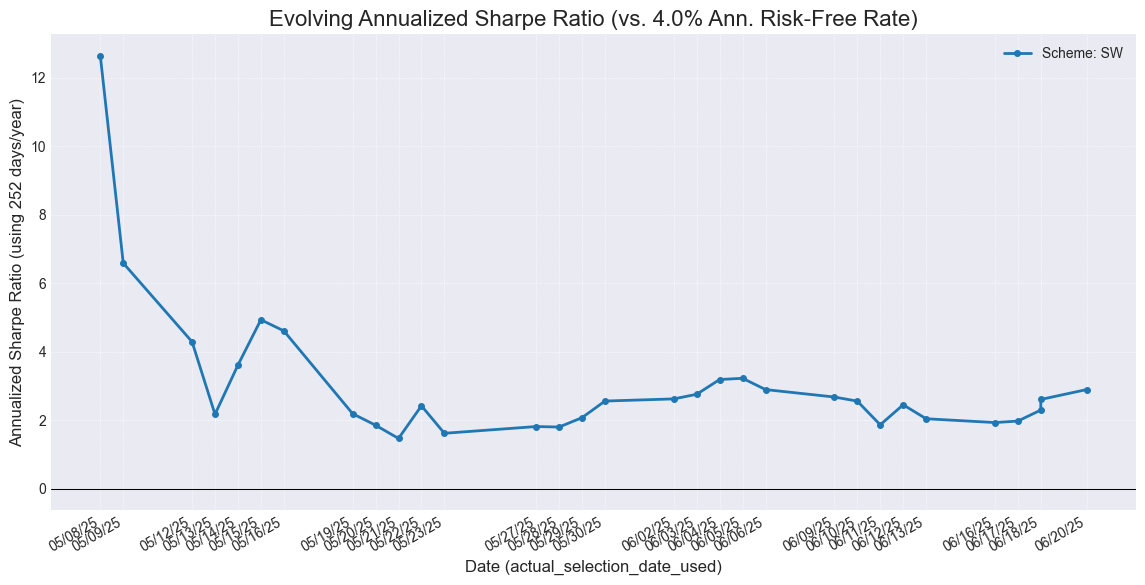

In [77]:
if 'df_summary' in locals() and not df_summary.empty:
    print("\n--- Step 3: Plotting Evolving Sharpe Ratio for the Top Strategy Run ---")
    
    # Get the parameters of the best strategy from our summary table
    top_strategy_params = df_summary.index[0]
    
    # Create a filter mask to select only the data for this specific run
    strategy_filter_mask = (df_results[STRATEGY_ID_COLS + ['scheme']] == top_strategy_params).all(axis=1)
    df_top_strategy = df_results[strategy_filter_mask]

    # Call the utility function
    utils.plot_evolving_annualized_sharpe(
        df=df_top_strategy, # Pass only the filtered data for the best strategy
        date_col='actual_selection_date_used',
        return_col='portfolio_return',
        scheme_col='scheme',
        annual_risk_free_rate=ANNUAL_RISK_FREE_RATE,
        trading_days_per_year=TRADING_DAYS_PER_YEAR,
        min_periods_for_sharpe=MIN_PERIODS_FOR_SHARPE
    )
else:
    print("Skipping visualization.")

### Below Cells are for Analysis

In [78]:
# See the names of all the groups pandas created
print("Available group names:")
print(list(grouped.groups.keys())[0:5]) # Print the first 5 group names
print(list(grouped.groups.values())[0:5]) # Print the first 5 group names


# Now, pick one of those names to inspect
# The name will be a tuple, e.g., (10, 10.0, 2.0, 0.35, 'EW')
a_specific_group_name = list(grouped.groups.keys())[0] 

print(f"\n--- Data for the specific group: {a_specific_group_name} ---")
display(grouped.get_group(a_specific_group_name))

Available group names:
[(10, 10.0, 2.0, 0.35, 'EW'), (10, 10.0, 2.0, 0.35, 'IV'), (10, 10.0, 2.0, 0.35, 'SW')]
[Index([0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 111, 114, 117], dtype='int64'), Index([1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 58, 61, 64, 67, 70, 73, 76, 79, 82, 85, 88, 91, 94, 97, 100, 103, 106, 109, 112, 115, 118], dtype='int64'), Index([2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59, 62, 65, 68, 71, 74, 77, 80, 83, 86, 89, 92, 95, 98, 101, 104, 107, 110, 113, 116, 119], dtype='int64')]

--- Data for the specific group: (10, 10.0, 2.0, 0.35, 'EW') ---


,actual_selection_date_used,average_return,filter_max_debt_eq,filter_min_avg_volume_m,filter_min_price,filter_min_roe_pct,inv_vol_col_name,log_file,n_select_actual,n_select_requested,num_attempted_trades,num_failed_or_skipped_trades,num_selected_tickers,num_successful_trades,portfolio_return,portfolio_return_normalized,run_timestamp,scheme,score_weight_change,score_weight_rel_volume,score_weight_rsi,score_weight_volatility,selection_date,sharpe_ratio_period,std_dev_return,total_weight_traded,win_rate
0,2025-06-20,0.0124,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250624_180741.log,10,10,10,0,10,10,0.0124,0.0124,2025-06-24 18:07:41,EW,0.3500,0.2000,0.3500,0.1000,2025-06-20,1.1240,0.0109,1.0000,0.9000
3,2025-06-18,0.0115,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250624_180741.log,10,10,10,0,10,10,0.0115,0.0115,2025-06-24 18:07:41,EW,0.3500,0.2000,0.3500,0.1000,2025-06-19,0.7506,0.0151,1.0000,0.7000
6,2025-06-18,0.0115,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250624_180741.log,10,10,10,0,10,10,0.0115,0.0115,2025-06-24 18:07:41,EW,0.3500,0.2000,0.3500,0.1000,2025-06-18,0.7506,0.0151,1.0000,0.7000
9,2025-06-17,-0.0016,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250624_180741.log,10,10,10,0,10,10,-0.0016,-0.0016,2025-06-24 18:07:41,EW,0.3500,0.2000,0.3500,0.1000,2025-06-17,-0.0909,0.0193,1.0000,0.5000
12,2025-06-16,-0.0017,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250624_180741.log,10,10,10,0,10,10,-0.0017,-0.0017,2025-06-24 18:07:41,EW,0.3500,0.2000,0.3500,0.1000,2025-06-16,-0.3033,0.0063,1.0000,0.4000
15,2025-06-13,-0.0103,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250624_180741.log,10,10,10,0,10,10,-0.0103,-0.0103,2025-06-24 18:07:41,EW,0.3500,0.2000,0.3500,0.1000,2025-06-13,-0.6430,0.0163,1.0000,0.3000
18,2025-06-12,0.0071,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250624_180741.log,10,10,10,0,10,10,0.0071,0.0071,2025-06-24 18:07:41,EW,0.3500,0.2000,0.3500,0.1000,2025-06-12,0.3213,0.0215,1.0000,0.6000
21,2025-06-11,-0.0178,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250624_180741.log,10,10,10,0,10,10,-0.0178,-0.0178,2025-06-24 18:07:41,EW,0.3500,0.2000,0.3500,0.1000,2025-06-11,-0.7959,0.0226,1.0000,0.2000
24,2025-06-10,-0.0016,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250624_180741.log,10,10,10,0,10,10,-0.0016,-0.0016,2025-06-24 18:07:41,EW,0.3500,0.2000,0.3500,0.1000,2025-06-10,-0.1175,0.0152,1.0000,0.4000
27,2025-06-09,-0.0033,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250624_180741.log,10,10,10,0,10,10,-0.0033,-0.0033,2025-06-24 18:07:41,EW,0.3500,0.2000,0.3500,0.1000,2025-06-09,-0.2777,0.0123,1.0000,0.5000
